# Neural Networks for Data Science Applications
## End-of-term homework: Recurrent neural networks and autoregressive modelling

**Name**: *Riccardo Corrente*

**Matricola**: *1964746*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 20th** session, you should upload it by **January 17th, 23:59 Rome time**.

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrand
import matplotlib.pyplot as plt

### Instructions

1. The homework is divided into three exercises. The first two (**10 points**) are mandatory for everyone. The third one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2025).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>. **Same goes for LLM-generated material**.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and JAX*: the homework must be done _fully in JAX_ (no external libraries) and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

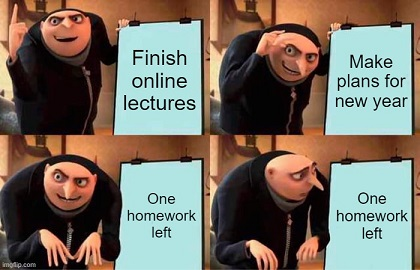

## Warmup: Data loading

For this part, select a dataset that is adequate for an autoregressive modelling task, keeping in mind task complexity with respect to the available hardware. Alternatively, take a generic dataset and transform it in a suitable way. Some examples (non exhaustive list):

1. Any text dataset can be converted to a next-token prediction dataset. You are free to use an existing tokenizer or train the tokenizer from scratch.
2. Time series are also naturally convertible to autoregressive scenarios.
3. For images you can convert them in multiple ways, e.g., as a sequence of pixels, as a sequence of patches (as in ViTs), as a sequence of bytes...
4. Other types of data, such as audio, graphs, DNA sequences, etc., are also feasible based on your interest.

> ⭕ For this homework, creativity is appreciated! Look around in the literature for inspiration (e.g., PixelRNN, pixel language modeling, audio autoregression, conditional models, ...). The fancier the better, according to your judgment.

*   You can use any data processing you want here (PyTorch data loaders, TensorFlow datasets, Grain, HuggingFace Dataset, ...).
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code. Describe the preprocessing you have applied. Show some examples of tokenized sequences and / or some statistics (e.g., tokens count, sequence length, ...).*

**TODO**: The dataset used in this project is derived from [Tatoeba](https://tatoeba.org/en/downloads), which offers paired translations of sentences across different languages. In particular, my goal is creating an English-to-Italian translator using a sequence-to-sequence (Seq2Seq) model with LSTM cells. The task involves translating short and simple sentences. To ensure the data is ready for training and to transform the text into numerical sequences suitable for the model, the following preprocessing steps were applied:

- **Preprocessing**: text converted to lowercase, punctuation is tokenized by adding spaces around it and some other procedures.

- **Tokenization**: creating a dictionary that maps every unique word to a number, for both languages (input and target). In particular target sequences are initialized and ended with special tokens (SOS and EOS).

- **Padding**: all sequences are padded to a uniform length to enable batch processing.

- **Embedding**: pre-trained (GloVe) embeddings are used to initialize the embedding matrix for input (English) words.

In [3]:
# TODO: Your code here.

 ### Loading data

In [4]:
# Install package for preprocessing
!pip install --quiet "keras_preprocessing"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00


In [5]:
# Download GloVe embeddings
!wget --quiet http://nlp.stanford.edu/data/glove.6B.zip
# Unzip the file
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [6]:
# Import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from jax import grad, jit
from jax.nn import one_hot
from jax.random import PRNGKey
import re
# import optax  # For adam optimization but I created a new function using only JAX

In [7]:
# Load the file from tatoeba
df = pd.read_csv('./sentences.tsv', sep='\t', header=None)

# Split the dataset into train and test sets
df = df.drop([0, 2], axis=1)
# Delete useless columns
df = df.rename(columns={1: 'input', 3: 'output'})
# Shuffle rows
df = df.sample(frac=1, random_state=42)
# As the dataset has more than half a million pairs of sentences,
# I'll use only 100k for training the model and 5000 for the test set,
# considering only brief sentences (less than 25 characters).
dataset = df[df['input'].str.len() < 25][1:100000]
dataset.head()

,input,output
604088,How can we end war?,Come possiamo fare finire la guerra?
287310,They're there alone.,Sono lì da soli.
548151,I'm a director.,Sono un direttore.
119108,That's an old joke.,È una vecchia barzelletta.
601672,Sami was feeling so sad.,Sami si stava sentendo così triste.


In [8]:
test_set = df[df['input'].str.len() < 25][100000:105000]
test_set.tail()

,input,output
374149,We need to follow her.,La dobbiamo seguire.
2477,Don't you like apples?,Non ti piacciono le mele?
627515,My mosquito bite itches.,La mia puntura di zanzara mi prude.
373164,Should we wait for them?,Dovremmo aspettarli?
544224,He'll try to help her.,Cercherà di aiutarla.


In [9]:
train_en = list(dataset['input'])
train_it = [str(item) for item in dataset['output']]

dataset = pd.DataFrame()
dataset['input'] = train_en
dataset['output'] = train_it

display(dataset.head(5))

,input,output
0,How can we end war?,Come possiamo fare finire la guerra?
1,They're there alone.,Sono lì da soli.
2,I'm a director.,Sono un direttore.
3,That's an old joke.,È una vecchia barzelletta.
4,Sami was feeling so sad.,Sami si stava sentendo così triste.


 ### Tokenizing the dataset

In [10]:
# Tokenizing the input (english sentences)
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r"([^\w\s'])", r' \1 ', text)  # Add spaces around punctuation except apostrophe
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply preprocessing
dataset['input'] = dataset['input'].apply(preprocess_text)

# Initialize and fit tokenizer

input_tokenizer = Tokenizer(filters="", oov_token="<OOV>") # handles out-of-vocabulary words
input_tokenizer.fit_on_texts(dataset['input'])

inputs_seq = input_tokenizer.texts_to_sequences(dataset['input'])
# Dictionary that maps every unique input word to the corresponding token
inputs_word2index = input_tokenizer.word_index
print('Total unique tokens in input:', len(inputs_word2index))

inputs_maxlen = max(len(s) for s in inputs_seq)
print('Max length of the input sentence:', inputs_maxlen, 'tokens')

print(inputs_word2index)


Total unique tokens in input: 9323
Max length of the input sentence: 10 tokens
{'<OOV>': 1, '.': 2, 'i': 3, 'you': 4, '?': 5, 'tom': 6, 'a': 7, 'is': 8, 'to': 9, 'he': 10, 'the': 11, 'it': 12, "i'm": 13, 'me': 14, 'do': 15, 'her': 16, 'we': 17, 'are': 18, 'she': 19, 'was': 20, 'him': 21, 'them': 22, 'have': 23, "don't": 24, 'this': 25, 'my': 26, 'that': 27, '!': 28, 'your': 29, "you're": 30, 'did': 31, 'they': 32, 'can': 33, ',': 34, 'not': 35, 'be': 36, 'like': 37, 'in': 38, 'what': 39, 'go': 40, 'here': 41, 'want': 42, 'now': 43, 'why': 44, "he's": 45, 'for': 46, 'mary': 47, 'of': 48, 'his': 49, "it's": 50, "can't": 51, 'very': 52, 'with': 53, 'know': 54, 'us': 55, 'has': 56, "i'll": 57, 'will': 58, 'need': 59, 'at': 60, "isn't": 61, 'help': 62, "didn't": 63, 'see': 64, 'so': 65, 'on': 66, 'all': 67, "we're": 68, 'how': 69, 'got': 70, 'please': 71, 'am': 72, 'were': 73, 'tell': 74, 'get': 75, 'home': 76, 'there': 77, 'love': 78, 'one': 79, 'come': 80, 'give': 81, 'up': 82, 'too': 83,

In [11]:
# Tokenizing the output (italian sentences)

def preprocess_output(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r"([^\w\s'])", r' \1 ', text)  # Add spaces around punctuation except apostrophe
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return ("<SOS> " + text + " <EOS>")

dataset['output'] = dataset['output'].apply(preprocess_output)

output_tokenizer = Tokenizer(filters="")
output_tokenizer.fit_on_texts(dataset['output'])

output_seq = output_tokenizer.texts_to_sequences(dataset['output'])
# Dictionary that maps every unique output word to the corresponding token
output_word2index = output_tokenizer.word_index
print('Total unique tokens in output:', len(output_word2index))

output_maxlen = max(len(s) for s in output_seq)
print('Max length of the input sentence:', output_maxlen, 'tokens')

print(output_seq[:5])

Total unique tokens in output: 17714
Max length of the input sentence: 16 tokens
[[1, 67, 134, 95, 1128, 9, 540, 4, 2], [1, 13, 123, 46, 1078, 3, 2], [1, 13, 15, 5457, 3, 2], [1, 5, 20, 572, 1313, 3, 2], [1, 85, 28, 195, 1345, 52, 205, 3, 2]]


### Padding the dataset

In [12]:
maxlen = 8

# Padding the sequences (<PAD> token = 0)
encoder_input_sequences = pad_sequences(inputs_seq, maxlen=maxlen, padding = 'post')
print('encoder_input_sequences shape:', encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_seq, maxlen=maxlen, padding='post')
print('decoder_inputs_sequences shape:', decoder_input_sequences.shape)


encoder_input_sequences = jnp.array(encoder_input_sequences)
decoder_input_sequences = jnp.array(decoder_input_sequences)

encoder_input_sequences shape: (99999, 8)
decoder_inputs_sequences shape: (99999, 8)


### Creating embedding for each word

In [13]:
# Creating the pretrained embedding_matrix for the english words (input)

embeddings_dict = dict()

glove_file = open('./glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector = np.asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector

glove_file.close()

# vocab_size
num_words = len(inputs_word2index)+1

# Initialize matrix with zeroes
embedding_matrix = np.zeros((num_words, 100))

for word, index in inputs_word2index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Input embedding matrix [vocab_size, embedding_dim]: where the
# t-th row represents the embedding of the t-th token
embedding_matrix = jnp.array(embedding_matrix)
embedding_matrix.shape

(9324, 100)

## Exercise 1: Training a recurrent model (7 points)

For this exercise, you are asked to implement a recurrent neural network, **entirely in JAX** (no higher-level libraries). Examples include all the content of Lecture 10 in the course (vanilla RNNs, structured state-space models, ...) but also other types of recurrent models you may find in the literature.

> 🟨 Depending on the implementation, you may need to be careful in the forward pass. For example, consider using [jax.lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) for implementing the loop of a vanilla RNN.

> 🟥 Remember that the homework must be done fully in JAX, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Importantly, describe carefully the design of the model. Train the model and show some plots to visualize the training (e.g., loss curves, perplexity, ...).*

**TODO**: To achieve the goal of creating a translator I decided to implement a sequence-to-sequence model with an Encoder-Decoder architecture, each powered by a single-layer[$^{1}$]() LSTM (Long Short-Term Memory) cell, implemented from scratch in JAX.


The model operates in two distinct workflows: one for training and another for generation, which will be implemented and explained in the second exercise.


**Training workflow**:
During training, the model learns to translate source sequences to target sequences through the following steps:

1. The *Encoder* processes the input sequence:

  - Converts tokens into embeddings.
  - Passes embeddings through the LSTM.
  - Outputs the final hidden and cell states.

2. The *Decoder* receives Encoder's final states.

3. At each timestep the *Decoder*:

  - Takes the ground truth token from the target sequence as input.
  - Processes it through the LSTM, updating its states.
  - Projects LSTM output to vocabulary space.
  - Outputs logits for loss computation.


[$^{1}$]()Adding more LSTM layers to both the encoder and decoder would follow the same approach, using the outputs of the previous layer as the inputs to the next layer. However, this would increase computational complexity, leading to longer training times and requiring more epochs for convergence. For this reason, I opted to use only a single LSTM layer for both the encoder and decoder.

In [14]:
# TODO: Your code here.

### LSTM cell

In [15]:
class LSTM:
    def __init__(self, num_inputs, hidden_dim):
        self.hidden_dim = hidden_dim
        self.num_inputs = num_inputs

    def init_params(self, key = jrand.PRNGKey(0)):
        """Initialize LSTM parameters properly for training"""
        k1, k2 = jax.random.split(key)

        # Initialize biases (as zero), size is 4 * hidden_dim for each gate
        b_ih = jnp.zeros((4 * self.hidden_dim,))
        b_hh = jnp.zeros((4 * self.hidden_dim,))

        # Initialize weight matrices with normal distribution
        w_ih = jax.random.normal(k1, shape=(self.num_inputs, 4 * self.hidden_dim)) * 0.01  # Scaled normal distribution
        w_hh = jax.random.normal(k2, shape=(self.hidden_dim, 4 * self.hidden_dim)) * 0.01  # Scaled normal distribution

        return {
            "w_ih": w_ih,
            "w_hh": w_hh,
            "b_ih": b_ih,
            "b_hh": b_hh
        }

    @staticmethod
    def forward(carry, x, params, emb = None):
        """Computes the LSTM's output for a single time step."""
        h, c = carry

        if emb != None:
          # Apply embedding if not already applied
          x = emb[x]

        # Compute gates with pre-activation splitting
        gates = (jnp.dot(x, params["w_ih"]) + params["b_ih"] +
                jnp.dot(h, params["w_hh"]) + params["b_hh"])

        # Split gates and apply activations separately for better gradient flow
        i, f, g, o = jnp.split(gates, 4, axis=-1)

        # Apply gate activations
        i = jax.nn.sigmoid(i)  # input gate
        f = jax.nn.sigmoid(f + 1.0)  # forget gate with +1.0 bias
        g = jnp.tanh(g)  # cell gate
        o = jax.nn.sigmoid(o)  # output gate

        # Update states
        new_c = f * c + i * g
        new_h = o * jnp.tanh(new_c)

        return (new_h, new_c), new_h

    @staticmethod
    def forward_full_sentence(carry, x, params):
        """Processes an entire input sequence by iteratively
           applying the LSTM cell to each time step, using jax.lax.scan"""
        def scan_fn(carry, x):
            h, c = carry

            # Compute gates with pre-activation splitting
            gates = (jnp.dot(x, params["w_ih"]) + params["b_ih"] +
                    jnp.dot(h, params["w_hh"]) + params["b_hh"])

            # Split gates and apply activations separately for better gradient flow
            i, f, g, o = jnp.split(gates, 4, axis=-1)

            # Apply gate activations
            i = jax.nn.sigmoid(i)  # input gate
            f = jax.nn.sigmoid(f + 1.0)  # forget gate with +1.0 bias
            g = jnp.tanh(g)  # cell gate
            o = jax.nn.sigmoid(o)  # output gate

            # Update states
            new_c = f * c + i * g
            new_h = o * jnp.tanh(new_c)
            return (new_h, new_c), new_h

        # Apply jax.lax.scan to process the input sequence
        # x: sequence of inputs, (batch_size, seq_len, input_dim)
        carry, outputs = jax.lax.scan(scan_fn, carry, x)

        return carry, outputs

In [16]:
### Example of LSTM usage

# Initialize LSTM
hidden_dim = 256
lstm = LSTM(num_inputs=100, hidden_dim=hidden_dim)

# Initialize parameters
key = jax.random.PRNGKey(0)
params = lstm.init_params(key)

sentence = encoder_input_sequences[0]
# Initial states for the LSTM (h, c)
initial_hidden_state = jnp.zeros((1, hidden_dim))  # dim = (batch_size, hidden_dim)
initial_cell_state = jnp.zeros((1, hidden_dim))  # dim = (batch_size, hidden_dim)

# Run the sentence through the LSTM with forward method
carry = initial_hidden_state, initial_cell_state
sentence_emb = embedding_matrix[sentence]  # Shape: (seq_len, embedding_dim)
carry, outputs = lstm.forward_full_sentence(carry, sentence_emb, params)

# Carry will contain the final hidden and cell states
final_hidden, final_cell = carry

# Outputs will contain the hidden states at each time step
print("Final hidden state:", final_hidden.shape)
print("Final cell state:", final_cell.shape)
print("Outputs (hidden states for each timestep):", outputs.shape)

Final hidden state: (1, 256)
Final cell state: (1, 256)
Outputs (hidden states for each timestep): (8, 1, 256)


### Encoder

In [17]:
class Encoder:
    def __init__(
        self,
        embedding_matrix,
        embedding_dim,
        hidden_dim,
    ):
        """
        Initialize the single-layer encoder.

        Args:
            embedding_dim: Dimension of the word embeddings.
            hidden_dim: Dimension of the LSTM hidden state.
        """
        self.embedding_dim = embedding_dim
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        self.lstm = LSTM(num_inputs=embedding_dim, hidden_dim=hidden_dim)

    def init_params(self, embedding_matrix, key = jrand.PRNGKey(0)):
        """Initialize encoder parameters."""
        # Split PRNG key for embeddings and LSTM

        # Initialize LSTM parameters
        lstm_params = self.lstm.init_params(key)

        return {
            "embeddings": embedding_matrix,
            "lstm": lstm_params
        }

    def init_state(self, batch_size: int):
        """Initialize the LSTM hidden and cell states."""
        return (
            jnp.zeros((batch_size, self.hidden_dim)),  # hidden state
            jnp.zeros((batch_size, self.hidden_dim))   # cell state
        )

    def forward(
        self,
        params,
        src_tokens,
        embedding_matrix,
        key=jrand.PRNGKey(0),
    ):
        """
        Forward pass through the encoder.

        Args:
            params: Dictionary containing model parameters
            src_tokens: Input token indices [batch_size, seq_len]
            src_mask: Mask for padding tokens [batch_size, seq_len]
            key: PRNG key

        Returns:
            tuple: (encoder_outputs, final_state)
                - encoder_outputs: Hidden states [batch_size, seq_len, hidden_dim]
                - final_state: Tuple of final (hidden_state, cell_state)
        """
        # To process single sentence:
        if src_tokens.ndim == 1:
          batch_size = 1
        else:
          batch_size = src_tokens.shape[0]

        # Get sequence embeddings
        embeddings = jnp.take(embedding_matrix, src_tokens, axis=0)

        if src_tokens.ndim != 1:
          embeddings = embeddings.transpose(1, 0, 2)  # Shape now: (seq_len, batch_size, embedding_dim)

        state = self.init_state(batch_size)

        # Process sequence through LSTM
        carry, outputs = self.lstm.forward_full_sentence(
            state,
            embeddings,
            params["lstm"],
        )

        # Apply mask if provided
        # if src_mask is not None:
        #    outputs = outputs * src_mask[:, :, None]

        return carry, outputs

In [18]:
### Example of encoder usage
encoder = Encoder(
    embedding_dim=100,
    embedding_matrix = embedding_matrix,
    hidden_dim=256,
)

# Initialize parameters
key = jax.random.PRNGKey(0)
params = encoder.init_params(embedding_matrix, key)

# Forward pass
src_tokens = encoder_input_sequences  # [batch_size, seq_len]
hidden, cell = encoder.forward(params, src_tokens, embedding_matrix)[0]

print("Hidden State:", hidden.shape)  # [batch_size, hidden_dim]
print("Cell State:", cell.shape)      # [batch_size, hidden_dim]

### Context Vector

Hidden State: (99999, 256)
Cell State: (99999, 256)


### Decoder

In [19]:
class Decoder:
    def __init__(self, embedding_dim, hidden_dim, embedding_matrix, key=jrand.PRNGKey(0)):
        """
        Initializes the Decoder module.

        Args:
            embedding_dim: Dimension of the word embeddings
            hidden_dim: Dimension of the LSTM hidden state
            pretrained_embedding: Pretrained embedding matrix (vocab_size x embedding_dim), optional
            key: PRNG key for parameter initialization
        """
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.embedding_matrix = embedding_matrix
        self.lstm = LSTM(num_inputs=embedding_dim, hidden_dim=hidden_dim)
        self.output_dim = embedding_matrix.shape[0]

    def init_params(self, embedding_matrix, key=jrand.PRNGKey(0)):
        """
        Initializes and returns the parameters for the Decoder.

        Args:
            key: PRNG key for parameter initialization

        Returns:
            params: A dictionary containing the decoder parameters
        """
        # Split key for parameter initialization
        k1, k2 = jax.random.split(key)

        # Initialize LSTM parameters
        lstm_params = self.lstm.init_params(k1)

        return {
            'lstm': lstm_params,
            'embeddings': embedding_matrix,
            'output_projection': {
                'weight': jax.random.normal(k2, (self.hidden_dim, self.output_dim)) * 0.1,
                'bias': jnp.zeros(self.output_dim)
            }
        }


    def forward(self, params, encoder_hidden, encoder_cell, target_sequence, embedding_matrix, key=jrand.PRNGKey(0)):
        """
        Performs the forward pass of the Decoder, using teacher forcing for training the model.
        In fact, at each time step t, the ground truth token (from the target_sequence) is directly used
        as the input to the decoder.

        Args:
            params: A dictionary of parameters containing:
                - 'lstm_params': Parameters for the LSTM layer
                - 'output_projection': Parameters for the output projection layer
            encoder_hidden: Final hidden state from encoder [batch_size, hidden_dim]
            encoder_cell: Final cell state from encoder [batch_size, hidden_dim]
            target_sequence: Target sequence indices [batch_size, seq_len]
            key: PRNG key

        Returns:
            Tuple of (outputs, final_hidden, final_cell)
            - outputs: Sequence of output vectors [seq_len, batch_size, vocab_size]
            - final_hidden: Final hidden state [batch_size, hidden_dim]
            - final_cell: Final cell state [batch_size, hidden_dim]
        """
        batch_size, seq_len = target_sequence.shape
        lstm_params = params['lstm']
        output_proj = params['output_projection']

        # Initialize decoder state with encoder's final states
        carry = (encoder_hidden, encoder_cell)

        # Store outputs for each timestep
        outputs = []

        for t in range(seq_len):
            # Get current timestep for all sequences
            current_input = target_sequence[:, t]
            current_input = jnp.take(embedding_matrix, current_input, axis=0)

            # Apply LSTM cell (batched)
            batched_lstm = jax.vmap(lambda x, c: self.lstm.forward(carry = c, x = x, params=lstm_params))
            # here the decoder is using the actual target token at time t
            # (not the predicted token from the previous step) as the input to the LSTM for the next time step.
            carry = batched_lstm(current_input, carry)[0]

            # Project hidden state to vocabulary space
            hidden = carry[0]
            logits = jnp.dot(hidden, output_proj['weight']) + output_proj['bias']
            outputs.append(logits)

        # Stack outputs
        outputs = jnp.stack(outputs, axis=0)  # [seq_len, batch_size, vocab_size]

        return outputs, carry[0], carry[1]


In [20]:
### Example of decoder usage

# Initialize decoder
embedding_dim = 100
hidden_dim = 256
vocab_size = len(output_word2index)

encoder = Encoder(
    embedding_dim=embedding_dim,
    embedding_matrix = embedding_matrix,
    hidden_dim=hidden_dim,
)

params = encoder.init_params(embedding_matrix, key)

# Forward pass
src_tokens = encoder_input_sequences[:5]  # [batch_size, seq_len]
final_hidden_state, final_cell_state = encoder.forward(params, src_tokens, embedding_matrix)[0]

# output embedding matrix initialized with normal values
out_embedding_matrix = jrand.normal(key, (vocab_size, embedding_dim))

decoder = Decoder(embedding_dim = embedding_dim,
                hidden_dim = hidden_dim,
                embedding_matrix = out_embedding_matrix)

params = decoder.init_params(out_embedding_matrix)
tgt_tokens = decoder_input_sequences[:5]

# During training
decoder_outputs, final_hidden, final_cell = decoder.forward(
    params = params,
    encoder_hidden=final_hidden_state,
    encoder_cell=final_cell_state,
    target_sequence=tgt_tokens,  # Your target sequences [batch_size, seq_len]
    embedding_matrix=out_embedding_matrix
)

decoder_outputs.shape

(8, 5, 17714)

### Seq2Seq

In [21]:
class Seq2Seq:
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        embedding_matrix,
        out_embedding_matrix,
        decoder_vocab_size,
        embedding_dim: int,
    ):
        """
        Seq2Seq model integrating encoder and decoder for sequence-to-sequence tasks.

        Args:
            encoder: Instance of Encoder class.
            decoder: Instance of Decoder class.
            embedding_matrix: Pretrained embedding matrix [vocab_size, embedding_dim].
        """
        self.encoder = encoder
        self.decoder = decoder
        self.embedding_matrix = embedding_matrix
        self.out_embedding_matrix = out_embedding_matrix
        self.decoder_vocab_size = decoder_vocab_size
        self.embedding_dim = embedding_dim

    def init_params(self, key=jrand.PRNGKey(0)):
        """
        Initialize parameters for the entire Seq2Seq model.

        Args:
            key: PRNG key for initialization.

        Returns:
            params: Dictionary containing encoder and decoder parameters.
        """
        k1, k2 = jrand.split(key)
        return {
            "encoder": self.encoder.init_params(self.embedding_matrix, k1),
            "decoder": self.decoder.init_params(self.out_embedding_matrix, k2),
        }

    def forward(self, params, src_tokens, target_tokens):
        """
        Forward pass through the Seq2Seq model.

        Args:
            params: Dictionary containing model parameters.
            src_tokens: Source token indices [batch_size, src_seq_len].
            target_tokens: Target token indices [batch_size, tgt_seq_len].

        Returns:
            outputs: Sequence of logits [tgt_seq_len, batch_size, vocab_size].
        """
        # Encode the source sequence
        encoder_embeddings = params['encoder']["embeddings"]
        decoder_embeddings = params['decoder']["embeddings"]
        encoder_params = params["encoder"]

        key_encoder, key_decoder = jrand.split(key)


        # Encode the source sequence
        carry, encoder_outputs = self.encoder.forward(
            encoder_params, src_tokens, encoder_embeddings, key=key_encoder
        )

        # Decode the target sequence
        decoder_params = params["decoder"]
        outputs, _, _ = self.decoder.forward(
            decoder_params,
            encoder_hidden=carry[0],
            encoder_cell=carry[1],
            target_sequence=target_tokens,
            embedding_matrix=decoder_embeddings,
            key=key_decoder,
        )

        return outputs


In [22]:
### Example of Seq2seq usage

# Define hyperparameters
embedding_dim = 100
hidden_dim = 256

# Create a random embedding matrix
key = jrand.PRNGKey(0)

# Initialize encoder and decoder
encoder = Encoder(embedding_matrix, embedding_dim, hidden_dim)
decoder = Decoder(embedding_dim, hidden_dim, out_embedding_matrix)

# Initialize Seq2Seq model
seq2seq = Seq2Seq(encoder, decoder, embedding_matrix, out_embedding_matrix=out_embedding_matrix,
                decoder_vocab_size=vocab_size, embedding_dim=embedding_dim)

# Initialize model parameters
params_key = jrand.PRNGKey(0)
params = seq2seq.init_params(params_key)

# Forward pass for 5 sequences from training set
logits = seq2seq.forward(params, encoder_input_sequences[:5], decoder_input_sequences[:5])

# Logits shape: [tgt_seq_len, batch_size, vocab_size]
print("Logits shape:", logits.shape)

Logits shape: (8, 5, 17714)


### Training

For training, I used the Adam algorithm to update the parameters because it significantly outperformed other methods I tried, such as SGD and SGD with momentum. Adam is particularly effective because it combines momentum and adaptive learning rates, which helps prevent issues like vanishing gradients. This was a problem I encountered with other techniques, making Adam the most suitable choice for this task.

Additionally, the model was trained using batches of data, which improved computational efficiency and allowed the model to generalize better.

In [61]:
# Hyperparameters (after playing a little bit with them I think these are ok, even
# if they can be enhanced based on the memory and the performance of the device)
learning_rate = 0.001
num_epochs = 20
batch_size = 256
vocab_size = len(output_word2index) + 1
embedding_dim = 100
hidden_dim = 256

# Initialize embedding matrix for outputs
out_embedding_matrix = jax.random.normal(PRNGKey(1), (vocab_size, embedding_dim))

# Initialize encoder, decoder, and Seq2Seq model
encoder = Encoder(
    embedding_matrix=embedding_matrix,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
)

decoder = Decoder(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    embedding_matrix=out_embedding_matrix
)

@jax.jit
def adam_update(params, grads, opt_state, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Implements the Adam optimizer update rule.

    Args:
        params: Model parameters.
        grads: Gradients of the loss w.r.t. parameters.
        opt_state: Optimizer state (m_t, v_t, t).
        lr: Learning rate.
        beta1: Exponential decay rate for the first moment estimates.
        beta2: Exponential decay rate for the second moment estimates.
        epsilon: Small value to prevent division by zero.

    Returns:
        updated_params: Updated model parameters.
        updated_opt_state: Updated optimizer state.
    """
    # Unpack the optimizer state
    m_t, v_t, t = opt_state

    # Update time step
    t += 1

    # Compute biased moment estimates
    m_t = jax.tree.map(lambda m, g: beta1 * m + (1 - beta1) * g, m_t, grads)
    v_t = jax.tree.map(lambda v, g: beta2 * v + (1 - beta2) * (g ** 2), v_t, grads)

    # Compute bias-corrected moment estimates
    m_hat = jax.tree.map(lambda m: m / (1 - beta1 ** t), m_t)
    v_hat = jax.tree.map(lambda v: v / (1 - beta2 ** t), v_t)

    # Update parameters
    updated_params = jax.tree.map(lambda p, m, v: p - lr * m / (jnp.sqrt(v) + epsilon), params, m_hat, v_hat)

    # Update optimizer state
    updated_opt_state = (m_t, v_t, t)
    return updated_params, updated_opt_state


def initialize_adam_state(params):
    """
    Initializes the Adam optimizer state for the given parameters.
    """
    m_t = jax.tree.map(jnp.zeros_like, params)
    v_t = jax.tree.map(jnp.zeros_like, params)
    t = 0
    return m_t, v_t, t


# Batch data generator
def batch_data(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

# Seq2Seq initialization
seq2seq_model = Seq2Seq(encoder, decoder, embedding_matrix, out_embedding_matrix, decoder_vocab_size=vocab_size, embedding_dim=embedding_dim)

# Initialize model parameters
trained_params = seq2seq_model.init_params(PRNGKey(0))

# Initialize optimizer state
opt_state = initialize_adam_state(trained_params)

@jax.jit
# Loss function
def loss_fn(params, src_tokens, target_tokens):
    """
    Computes the loss for the seq2seq model
    """
    logits = seq2seq_model.forward(params, src_tokens, target_tokens)
    logits = logits.transpose((1, 0, 2)) # [batch_size, tgt_seq_len, vocab_size]

    # Align logits and target tokens for teacher forcing
    target_one_hot = jax.nn.one_hot(target_tokens[:, 1:], logits.shape[-1])
    logits = logits[:, :-1, :]   # Ignore the last time step
    log_probs = jax.nn.log_softmax(logits, axis=-1)
    loss = -jnp.mean(jnp.sum(target_one_hot * log_probs, axis=-1))
    return loss

def loss_fn_2(params, src_tokens, target_tokens, padding_idx=0):
    """
    Computes the loss for the seq2seq model, masking the padding tokens.
    """
    logits = seq2seq_model.forward(params, src_tokens, target_tokens)
    logits = logits.transpose((1, 0, 2))  # [batch_size, tgt_seq_len, vocab_size]

    # Align logits and target tokens for teacher forcing
    target_one_hot = jax.nn.one_hot(target_tokens[:, 1:], logits.shape[-1])
    logits = logits[:, :-1, :]  # Ignore the last time step

    # Compute loss while masking padding tokens
    mask = (target_tokens[:, 1:] != padding_idx).astype(jnp.float32)
    log_probs = jax.nn.log_softmax(logits, axis=-1)
    loss = -jnp.sum(mask * jnp.sum(target_one_hot * log_probs, axis=-1)) / mask.sum()
    return loss


# Training step
@jax.jit
def train_step(params, opt_state, batch_src, batch_tgt):
    """
    Perform a single train steps, updating parameters.
    """
    loss, grads = jax.value_and_grad(loss_fn)(params, batch_src, batch_tgt)
    params, opt_state = adam_update(params, grads, opt_state, learning_rate)
    return loss, params, opt_state

# Training loop
history_loss = []
checkpoint_interval = 5

for epoch in range(num_epochs):
    epoch_loss = 0
    batch_count = 0
    # Iterate through the batches
    for batch_src, batch_tgt in batch_data(encoder_input_sequences, decoder_input_sequences, batch_size):
        loss, trained_params, opt_state = train_step(trained_params, opt_state, batch_src, batch_tgt)
        epoch_loss += loss
        batch_count += 1
    # Compute and print the average loss for the batches of each epoch
    avg_loss = epoch_loss / batch_count
    history_loss.append(avg_loss)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    # The code runs for about 3/4 hours, so it is useful to save parameters every epoch
    # Save periodically to disk
    import pickle
    if (epoch + 1) % checkpoint_interval == 0:
        with open(f"checkpoint_epoch.pkl", "wb") as f:
            pickle.dump(trained_params, f)


Epoch 1, Average Loss: 3.5721
Epoch 2, Average Loss: 2.4183
Epoch 3, Average Loss: 1.8507
Epoch 4, Average Loss: 1.4630
Epoch 5, Average Loss: 1.1708
Epoch 6, Average Loss: 0.9497
Epoch 7, Average Loss: 0.7838
Epoch 8, Average Loss: 0.6586
Epoch 9, Average Loss: 0.5624
Epoch 10, Average Loss: 0.4889
Epoch 11, Average Loss: 0.4325
Epoch 12, Average Loss: 0.3894
Epoch 13, Average Loss: 0.3547
Epoch 14, Average Loss: 0.3252
Epoch 15, Average Loss: 0.2996
Epoch 16, Average Loss: 0.2780
Epoch 17, Average Loss: 0.2599
Epoch 18, Average Loss: 0.2450
Epoch 19, Average Loss: 0.2317
Epoch 20, Average Loss: 0.2198


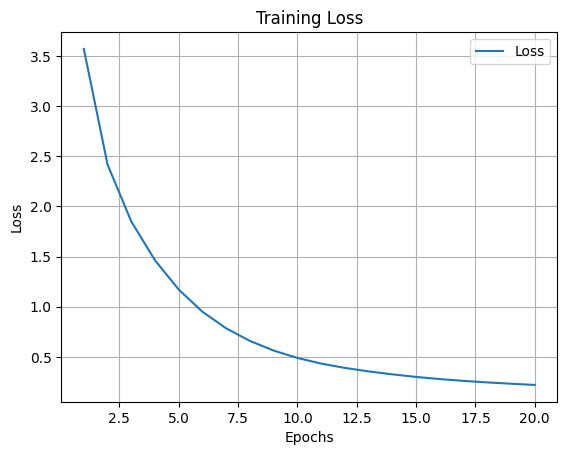

In [62]:
epochs = range(1, len(history_loss) + 1)

# Plot of the average loss for the batches of each epoch
plt.plot(epochs, history_loss, label="Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# The loss is decreasing and approaching zero,
# indicating that the model is effectively learning from the training data.

## Exercise 2: Autoregressive generation (3 points)

For this exercise, run the trained model in an autoregressive fashion and show some examples of generated sequences. Note that the details will depend on the specific type of data (e.g., sampling text tokens, sampling pixels as discrete values, sampling pixels from a continuous range of colours, ...). For this, refer also to Section 8.4 of the book.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Show some examples of generated sequences.*

**TODO**: The following describes how the model works when it generates a translation:

**Generation workflow**:
1. The input sequence (a tokenized and padded English sentence) is encoded using the same process as during training, producing the encoder's hidden and cell states.

2. The Decoder starts with the start token (<SOS>) as the initial input.

3. At each timestep, until *'max_length'* is reached, the following steps are repeated:

  - The current token is embedded using the embedding matrix.
  - The embedded vector is passed through the LSTM, updating the hidden and cell states.
  - The updated hidden state is projected into the vocabulary space, producing logits.
  - The next token is determined by applying an argmax operation on the logits (deterministic selection).
  - The selected token is fed back into the decoder as input for the next timestep in an autoregressive way.


 4. The complete generated sentence is returned as output.


In [26]:
# TODO: Your code here.

### Decoder generate

In [27]:
def generate(self, params, encoder_hidden, encoder_cell, start_token, max_length, key=jrand.PRNGKey(0)):
    """
    Generates a sequence using the decoder in an auto-regressive way, using the previous
    generated tokens to return the output.
    Args:
        params: A dictionary of parameters containing:
            - 'lstm_params': Parameters for the LSTM layer
            - 'output_projection': Parameters for the output projection layer
        encoder_hidden: Final hidden state from encoder [batch_size, hidden_dim]
        encoder_cell: Final cell state from encoder [batch_size, hidden_dim]
        start_token: Token to start generation with
        max_length: Maximum sequence length to generate
        key: PRNG key for sampling
    Returns:
        Generated sequence indices [batch_size, max_length]
    """
    batch_size = encoder_hidden.shape[0]
    carry = (encoder_hidden, encoder_cell)
    lstm_params = params['lstm']
    # Initialize with start token
    current_token = jnp.full((batch_size,), start_token)
    generated = [current_token]
    embedding_matrix = params['embeddings']  # Get embedding matrix from params

    # N.B. I could've also used a break point when <EOS> token is returned, but the
    # results are similar.
    for _ in range(max_length - 1):
       # Get current timestep for all sequences
        current_emb = jnp.take(embedding_matrix, current_token, axis=0)

        # Apply LSTM cell (batched)
        batched_lstm = jax.vmap(lambda x, c: self.lstm.forward(carry = c, x = x, params=lstm_params))
        carry = batched_lstm(current_emb, carry)[0]

        # Project to vocabulary space and sample
        hidden = carry[0]
        logits = jnp.dot(hidden, params['output_projection']['weight']) + params['output_projection']['bias']

        # Sample next token (using argmax for deterministic generation)
        current_token = jnp.argmax(logits, axis=-1)
        generated.append(current_token)

    return jnp.stack(generated, axis=1)  # [batch_size, max_length]

# Add the generate function to the class 'Decoder' defined before
Decoder.generate = generate


### Seq2Seq generate

In [28]:
def generate(self, params, src_tokens, start_token, max_length, key=jrand.PRNGKey(0)):
    """
    Generate a target sequence given a source sequence.
    Args:
        params: Dictionary containing model parameters.
        src_tokens: Source token indices [batch_size, src_seq_len].
        start_token: Token to start generation with.
        max_length: Maximum sequence length to generate.
        key: PRNG key for sampling.
    Returns:
        generated: Generated sequence indices [batch_size, max_length].
    """
    # Encode the source sequence
    encoder_params = params["encoder"]
    carry, _ = self.encoder.forward(encoder_params, src_tokens, encoder_params['embeddings'])

    # Decode and generate target sequence
    decoder_params = params["decoder"]
    return self.decoder.generate(
        decoder_params,
        encoder_hidden=carry[0],
        encoder_cell=carry[1],
        start_token=start_token,
        max_length=max_length,
        key=key,
    )

# Add the generate function to the class 'Seq2seq' defined before
Seq2Seq.generate = generate


### Trying some queries

In [51]:
# Dictionaries that map each token to its corresponding word.
inverted_dict_out = {v: k for k, v in output_word2index.items()}
inverted_dict_inp = {v: k for k, v in inputs_word2index.items()}
inverted_dict_inp[0] = '<PAD>'
inverted_dict_out[0] = '<PAD>'

def token_to_word(arr, dictionary):
    """
    Converts a JAX array of tokens into the corresponding string using the provided dictionary.
    """
    if isinstance(arr, str):
      return(arr)

    tokens = arr.tolist()  # Convert JAX array to a list
    out = " ".join(dictionary[token] for token in tokens)
    return out


In [52]:
def translate(input_sentence, params, max_length, start_token, tokenizer = None):
    """
    Translate an input sentence using the trained encoder and decoder.

    Args:
        input_sentence: The input sentence to translate.
        params: Trained parameters of the decoder.
        max_length: Maximum length of the output sequence.
        start_token: Index of the <SOS> token.

    Returns:
        str: The translated sentence.
    """
    if isinstance(input_sentence, str):
        if tokenizer is None:
            raise ValueError("A tokenizer function must be provided for string inputs.")
        input_sentence = preprocess_text(input_sentence)
        app = tokenizer.texts_to_sequences([input_sentence])
        input_sentence = pad_sequences(app, maxlen = max_length, padding = 'post')

    # Ensure the tokenized sentence is a jnp.array
    if not isinstance(input_sentence, jnp.ndarray):
        input_sentence = jnp.array(input_sentence)

    encoder_params, decoder_params = params['encoder'], params['decoder']
    # Encode the input sequence
    encoder_output = encoder.forward(encoder_params, input_sentence, encoder_params['embeddings'])

    final_hidden, final_cell = encoder_output[0]

    # Generate the translation
    generated_sequence = decoder.generate(
        params=decoder_params,
        encoder_hidden=final_hidden,
        encoder_cell=final_cell,
        start_token=start_token,
        max_length=max_length,
    )

    return generated_sequence[0]

In [53]:
input_sentence = str(input("Enter an english sentence to be translated: "))
maxlen = 8
sos_token = 1

translated_sentence = translate(input_sentence, trained_params, maxlen, sos_token, input_tokenizer)
print("Input:", token_to_word(input_sentence, inverted_dict_inp))
print("Translation: ", token_to_word(translated_sentence, inverted_dict_out))

Enter an english sentence to be translated: How are the things going on?
Input: How are the things going on?
Translation:  <sos> come vanno le cose ? <eos> <PAD>


In [54]:
for i in test_set['input'][:100]:
  print(i)
  print(token_to_word(translate(i, trained_params, maxlen, sos_token, input_tokenizer), inverted_dict_out))

He sympathized.
<sos> capì . <eos> <PAD> <PAD> <PAD> <PAD>
Give us a minute.
<sos> dacci un minuto . <eos> <PAD> <PAD>
Are you going to bed?
<sos> lei sta andando a letto ? <eos>
They won't let you in.
<sos> non ti lasceranno entrare . <eos> <PAD>
Tomorrow?
<sos> domani ? <eos> <PAD> <PAD> <PAD> <PAD>
How did you find it?
<sos> come l'hai trovata ? <eos> <PAD> <PAD>
Do you like basketball?
<sos> le piace il basket ? <eos> <PAD>
Do you pray?
<sos> prega ? <eos> <PAD> <PAD> <PAD> <PAD>
Tom is a twin, isn't he?
<sos> tom è un gemello , vero ?
Summer isn't over yet!
<sos> l'estate non è ancora finita ! <eos>
The baby smiled at me.
<sos> il bebè mi sorrise . <eos> <PAD>
I have little to do.
<sos> ho un po' di fare . <eos>
He knows how to party.
<sos> sa com'è conosciuto la festa . <eos>
He accepted his offer.
<sos> ha accettato la sua offerta . <eos>
Tom won't get it.
<sos> tom non la farà . <eos> <PAD>
It's human nature.
<sos> è vero . <eos> <PAD> <PAD> <PAD>
I love baseball.
<sos> io amo 

### Conclusions and improvements

In conclusion, I have succesfully developed a Seq2Seq model using LSTM cells to translate short and simple sentences from English to Italian. The model demonstrates the ability to generate meaningful translations for sentences that are syntactically similar to those in the training set. Additionally, it demonstrates the ability to handle different sentences, maintaining contextual understanding, despite the limited number of parameters.

Obviously, there are several areas where the model could be improved to generalize better to more diverse and longer sentences and to prevent overfitting. Some potential improvements include:

  - Using **subword-based tokenizer**, rather than simply mapping words to integers, could enable the model to grasp out-of-vocabulary words meanings and recognize similarities between related words (e.g "listen", "listens", "listening").

  - Adding more LSTM layers (**improving model's depth**) to both the encoder and decoder could improve performance by increasing the model's capacity to learn and represent complex patterns. A deeper encoder would better understand and represent the input sentence, while a deeper decoder would generate more accurate translations.

  - Incorporating **attention mechanism** could significantly improve the model's ability to focus on relevant parts of the input sentence during decoding, particularly when dealing with longer or more complex sentences.

  - Introducing **dropout regularization** to the LSTM layers and embeddings would help prevent overfitting and improve generalization.

Additionally, having a more powerful device could help process larger training sets and dictionaries, given the vast number of sentences in a language.

By applying these improvements, the model could perform better and provide more accurate and reliable translations.

### References

[1] Aston Zhang, Zachary C. LiptoN, Mu Li, Alexander J. Smola. *Dive into Deep Learning*,  [2024](https://d2l.ai/chapter_recurrent-modern/lstm.html)

[2] Rajarshi C, [translate.ipynb](https://github.com/likarajo/language_translation/blob/master/translate.ipynb)

[3] bentrevett/pytorch-seq2seq, [seq2seq](https://github.com/bentrevett)

[4] Some references from [here](https://medium.com/analytics-vidhya/lstms-explained-a-complete-technically-accurate-conceptual-guide-with-keras-2a650327e8f2)

## Exercise 3: Beam search (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercises 1&2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1&2&3 for a total of *15 points*.

In standard autoregressive modeling, at every iteration you sample the element with the highest associated probability (e.g., the $\arg\max$ for a discrete distribution). This is known as **greedy decoding**. However, this may result in completed sequences with low probability.

A common modification is **beam search** ([link](https://d2l.ai/chapter_recurrent-modern/beam-search.html)), where at every iteration we keep track of $k$ possible sequences (called **beams**). See also Section 8.4.2 in the book.

**TODO**: For this exercise, implement a beam search decoding procedure for your model, and show some examples of generation, comparing them to the result of greedy decoding.

In [ ]:
# TODO: Your code here.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

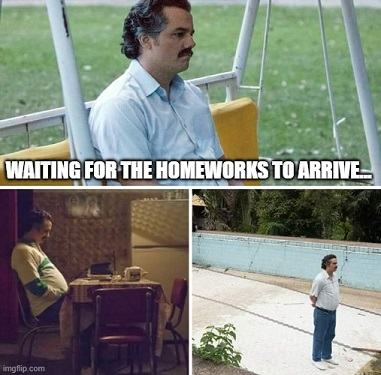